In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data
from mldec.models import baselines
from mldec.utils import evaluation
from mldec.codes import repetition_code

In [ ]:
def compare_slice_by_column(df, column, slice_by):
    best = df[df[slice_by] == 1]
    other = df[df[slice_by] != 1]
    best = best[column]
    other = other[column]
    if column == 'lr':
        best = np.log10(best)
        other = np.log10(other)
    cts, bins, _ = plt.hist(best, bins=20, alpha=1, color='r', label='perfect')
    plt.hist(other, bins=bins, alpha=0.5, color='b', label='rest')
    plt.legend()
    plt.title(column)
    plt.show()

check_hypers = False
if check_hypers:
    # target = "mldec_results.xlsx"
    target = "ffnn-v0.2/ffnn_toy_problem_only_good_examples_results.csv"
    df_ffnn = pd.read_csv(target)
    ffnn_columns = ['lr', 'dropout', 'hidden_dim', 'n_layers', 'batch_size']
    for column in ffnn_columns:
        compare_slice_by_column(df_ffnn, column, 'val_acc')

    df = pd.read_excel("mixed-v0/mldec_results.xlsx", sheet_name=None)
    df_cnn = df['cnn_toy_problem_only_good_examp']
    df_xformer = df['xformer_only_good_examples']
    cnn_columns = ['lr', 'dropout', 'kernel_size', 'conv_channels', 'n_layers', 'batch_size']
    xformer_columns = ['lr', 'dropout', 'd_model', 'num_encoder_layers', 'num_decoder_layers', 'nhead', 'dim_feedforward', 'batch_size']
    for column in cnn_columns:
        compare_slice_by_column(df_cnn, column, 'val_acc')
    for column in xformer_columns:
        compare_slice_by_column(df_xformer, column, 'val_acc')

In [21]:
# model = "transformer"
target_xformer = "results/transformer_toy_problem_unbiased/transformer_toy_problem_unbiased_results.csv"
target_cnn = "results/cnn_toy_problem_unbiased/cnn_toy_problem_unbiased_results.csv"
target_ffnn = "results/ffnn_toy_problem_unbiased/ffnn_toy_problem_unbiased_results.csv"
df_x = pd.read_csv(target_xformer)
df_cnn = pd.read_csv(target_cnn)
df_ffnn = pd.read_csv(target_ffnn)

# split into two different dfs: batch_size=250 and batch_size=1994
df_x_250 = df_x[df_x['batch_size'] == 250]
df_x_1994 = df_x[df_x['batch_size'] == 1994]
df_cnn_250 = df_cnn[df_cnn['batch_size'] == 250]
df_cnn_1994 = df_cnn[df_cnn['batch_size'] == 1994]
df_ffnn_250 = df_ffnn[df_ffnn['batch_size'] == 250]
df_ffnn_1994 = df_ffnn[df_ffnn['batch_size'] == 1994]

dfs_250 = [df_x_250, df_cnn_250, df_ffnn_250]
dfs_1994 = [df_x_1994, df_cnn_1994, df_ffnn_1994]


In [4]:
# compute optimal performance on this dataset
p = 0.1
alpha = 1
n = 8
dataset_config = {"p": p, "alpha": alpha, "pcm": toy_problem_data.repetition_pcm(n)}
X, Y, good_weights = toy_problem_data.uniform_over_good_examples(n, dataset_config)
X, Y, true_weights = toy_problem_data.create_dataset_training(n, dataset_config)

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, true_weights) 
print(f"Lookup table accuracy: {mld_acc}")

Lookup table accuracy: 0.9972717761993408


/Users/e6peters/projects/mldec/src/mldec/models/baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(out)


In [5]:
# solve for the violation of wellorderedness 
def froot(x):
    return (x / (1-x)) ** 4 - ( (alpha * x) / (1 - alpha * x)) ** 2

# find the root
from scipy.optimize import root_scalar
root = root_scalar(froot, x0=0.5) #overshoot since 0 is also a root

In [6]:
n_samp = 8
alpha_samp = 1
p1_samp = 0.1
p2_samp = p1_samp * alpha
good_wt_hist, unimp_wt_hist, imp_wt_hist, bad_wt_hist, all_wt_hist = repetition_code.histogram_good_important_bad(n_samp, p1_samp, alpha_samp)
# turning the knob
pp_samp = 0.25
good_wt_hist_k, unimp_wt_hist_k, imp_wt_hist_k, bad_wt_hist_k, all_wt_hist_k = repetition_code.histogram_good_important_bad(n_samp, pp_samp, alpha_samp)
weights = np.array(list(imp_wt_hist.keys()))

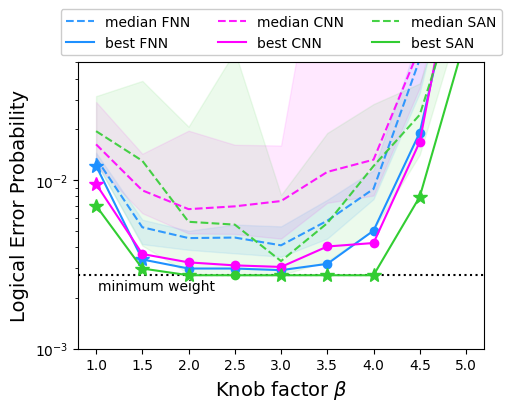

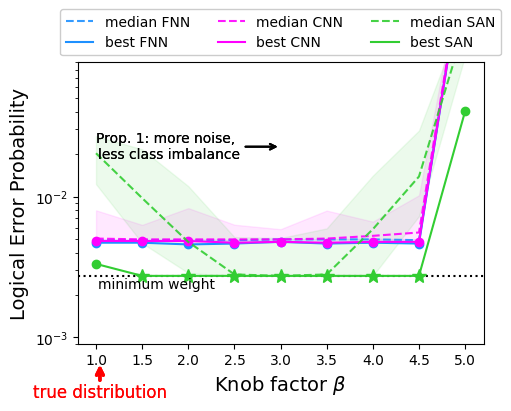

In [25]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
# Create two separate figures, one for each axis
fig0, ax0 = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
axes = [ax0, ax1]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1A: DISTRIBUTION OF EXAMPLES FOR GOOD/BAD/IMPORTANT
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1B: PERFORMANCE WITH TURNING THE KNOB
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#get the min weight performance
colors = ['dodgerblue', 'fuchsia', 'limegreen']
for k,(df_x, df_cnn, df_ffnn )in enumerate([dfs_250, dfs_1994]):
    ax = axes[k]
    vs_minweight = df_x[df_x['p'] == p]['vs_minweight'].values
    minweight = df_x[df_x['p'] == p]['val_acc'] - vs_minweight
    min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...
    ax.axhline(min_minweight_err, ls=':', c='k', alpha=1)#, label='minimum weight')
    # ax.axhline(1 - mld_acc , ls=':', c='k', alpha=0.8)#, label='MLD')
    ax.text(1.02, min_minweight_err - 0.0005, f"minimum weight", c='k', size=10, ha='left')
    # ax.text(1.02, 1 - mld_acc + 0.00005 , f"MLD", size=10, ha='left')

    for jj, (df, model) in enumerate(zip([df_ffnn, df_cnn, df_x], ['FNN', 'CNN', 'SAN'])):
    
        # compute performance/stats on each of the models
        pvals = sorted(df['p'].unique())
        xvals = np.array(pvals) / 0.1
        yerrs_meds = []
        yerrs_mins = []
        yerrs_ub = []
        yerrs_lb = []
        better_than_lookup_arr = [] # track when the model is better than the lookup table
        for i, p in enumerate(pvals):
            y = df[df['p'] == p]['val_acc']
            y_err = 1 - y
            yerrs_meds.append(y_err.median())
            # get 
            y_ub = y_err.quantile(.75)
            y_lb = y_err.quantile(0.25)
            yerrs_ub.append(y_ub)
            yerrs_lb.append(y_lb)
            yerrs_mins.append(y_err.min())

            # # Also get the min weight performance
            # vs_minweight = df[df['p'] == p]['vs_minweight'].values
            # minweight = y - vs_minweight
            # min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

            # now, find the comparison of this plot to the lookup table on the plot
            vs_lookup = df[df['p'] == p]['vs_lookup'][y.idxmax()]
            better_than_lookup = vs_lookup > 0
            better_than_lookup_arr.append(better_than_lookup)
        
        yerrs_meds = np.array(yerrs_meds)
        yerrs_mins = np.array(yerrs_mins)
        yerrs_ub = np.array(yerrs_ub)
        yerrs_lb = np.array(yerrs_lb)
        color = colors[jj]
        ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.09)
        ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.9, label=f'median {model}')
        ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=f'best {model}')
        # wherever the result is better than lookup, plot a star
        for i, p in enumerate(pvals):
            if better_than_lookup_arr[i]:
                marker = '*'
                markersize = 10
            else:
                marker = 'o'
                markersize = 6
            ax.plot(p / 0.1, yerrs_mins[i], marker=marker, c=color, markersize=markersize)



    ax.set_xlabel(r"Knob factor $\beta$", size=14)
    # draw an arrow pointing to x=0.10, y=0.01
    ax.semilogy()
    ax.legend(framealpha=1, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([9e-4, 9e-2])
    ax.set_ylabel("Logical Error Probability", size=14)
        
    # Add an arrow annotation below the x-axis pointing at x=1
    axes[1].annotate("true distribution", 
                xy=(0.055, -0.05 ),  # Use axis coordinates (x, y)
                xytext=(0.055, -0.14),  # Position text below the axis using axis coordinates
                size=12,  
                ha='center',
                va='top',
                color='red',
                # fontweight='bold',  # Make text bold to increase visibility
                # bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', pad=3),  # Add background to text
                arrowprops=dict(
                    arrowstyle='->',
                    color='red',
                    linewidth=2.5,  # Increased linewidth for visibility
                    shrinkA=0,
                    shrinkB=5  # Added some shrinkage to avoid overlapping with text
                ),
                xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
                textcoords='axes fraction')  # Use axis fraction coordinates for the text
    axes[1].annotate("Prop. 1: more noise, \nless class imbalance", 
                xy=(0.5, .7 ),  # Use axis coordinates (x, y)
                xytext=(0.4, .7 ),  # Position text further left to avoid overlap
                size=10,  
                ha='right',
                va='center',
                color='k',
                # bbox=dict(facecolor='white', alpha=0.7, edgecolor='k', pad=3),  # Add background to text
                arrowprops=dict(
                    arrowstyle='->',
                    color='k',
                    linewidth=1.5,  # Increased linewidth for visibility
                    # shrinkA=200,  # Ensure arrow starts outside the text box
                    # shrinkB=200  # Added some shrinkage to avoid overlapping with text
                ),
                xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
                textcoords='axes fraction')  # Use axis fraction coordinates for the text

    axes[1].annotate("", xy=(0.10, yerrs_mins[0] * .9), xytext=(0.10, yerrs_mins[0] *.35 ), arrowprops=dict(arrowstyle='->', color='r', linewidth=2))


axes[0].set_ylim(1e-3, 5e-2)
fig0.savefig(f"../../figures/fig1_unbiased.pdf", bbox_inches='tight')